In [1]:
from maddpg.maddpg import MADDPG
from maddpg.buffer import MultiAgentReplayBuffer
from torch.utils.tensorboard import SummaryWriter
from PIL import Image, ImageDraw
import torch as T
import numpy as np
from tools.scopa_env import *
from tools.scopone_scientifico_sim import *
import datetime
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
scenario = f'testMADDPG_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S_binaryactionsetbuffer")}'

In [3]:
env = ScopaEnv()
n_agents = 4
actor_dims = [120 for _ in range(n_agents)]
critic_dims = sum(actor_dims)

In [4]:
n_actions = 40
maddpg_agents = MADDPG(actor_dims, critic_dims, n_agents, n_actions, 
                           fc1=64, fc2=64,  
                           alpha=0.01, beta=0.01, scenario=scenario,
                           chkpt_dir='tmp/maddpg/')

memory = MultiAgentReplayBuffer(1000000, critic_dims, actor_dims, 
                        n_actions, n_agents, batch_size=1024)

def obs_list_to_state_vector(observation):
    state = np.array([])
    for obs in observation:
        state = np.concatenate([state, obs])
    return state

In [5]:
writer = SummaryWriter(log_dir=f'runs/{scenario}')

In [6]:
# Preload card images for tensorboard:)
def preload_card_images(image_folder = '/workspace/ScopaAI_ToM/res/cards', scale_factor=0.1):
    """
    Preload all card images and scale them down dramatically to save resources.
    Args:
        image_folder (str): Path to folder containing card images.
        scale_factor (float): Factor by which to scale down images.
    Returns:
        dict: Dictionary mapping card indices to scaled-down images.
    """
    card_images = {}
    for filename in os.listdir(image_folder):
        if filename.endswith(".png"):
            # Extract rank and suit from filename
            card_name = filename.split(".")[0]  # Remove extension
            rank, suit = card_name.split("_of_")
            
            # Map suit to its corresponding value
            suit_values = {"diamonds": 30, "clubs": 20, "spades": 10, "hearts": 0}
            suit_value = suit_values[suit]

            if rank == "jack":
                rank = 8
            elif rank == "queen":
                rank = 9
            elif rank == "king":
                rank = 10
            elif rank == "ace":
                rank = 1
            
            # Calculate card index based on the new rule
            card_index = int(rank) + suit_value - 1
            
            # Load and scale down image
            image = Image.open(os.path.join(image_folder, filename))
            new_size = (int(image.width * scale_factor), int(image.height * scale_factor))
            scaled_image = image.resize(new_size)
            
            # Add to dictionary
            card_images[card_index] = scaled_image
    return card_images

card_images = preload_card_images()

In [7]:
def local_state_to_image(state, action, reward, score = None, player = None):
    if state is None:
        return None

    if len(state.flatten()) != 120:
        raise ValueError('Local State must be 120 elements, received: ', len(state.flatten()))

    # Initialize image sections
    sections = {
        "Hand": state[:40],
        "Table": state[40:80],
        "Captures": state[80:120]
    }

    # Dimensions and image settings
    card_width, card_height = next(iter(card_images.values())).size
    card_width = int(card_width)
    card_height = int(card_height)
    row_width = 10  # Number of cards per row
    section_padding = 50  # Padding for the section labels
    section_spacing = 20  # Space between sections
    section_height = card_height + section_padding  # Total height of each section (cards + label)
    combined_height = (section_height * len(sections)) + (section_spacing * (len(sections) - 1))  # Total height
    combined_width = card_width * row_width  # Total width of the final image

    # Create the combined image with a black background
    combined_image = Image.new("RGBA", (combined_width, combined_height), (0, 0, 0, 255))
    draw = ImageDraw.Draw(combined_image)

    image_info_x = combined_width - 200
    image_info_y = 10

    if score is not None and player is not None:
        draw.text((image_info_x, image_info_y), f'Player {player.__hash__()}|Side {player.side}|Score{score}', fill="white")

    draw.text((image_info_x-70, image_info_y), f'Reward: {reward}', fill="white", fontsize=20)    

    # Process each section (Hand, Table, Captures)
    y_offset = 0
    for section_name, section_state in sections.items():
        # Draw section label
        draw.text((10, y_offset + 10), section_name, fill="white")

        # Place cards in the current section
        active_indices = np.where(section_state != 0)[0]
        for i, index in enumerate(active_indices):
            # Calculate the correct card index for the global state
            card_index = index + {"Hand": 0, "Table": 40, "Captures": 80}[section_name]
            
            if index in card_images:
                card_image = card_images[index].resize((card_width, card_height))
                x = (i % row_width) * card_width
                y = y_offset + section_padding  # Place cards below the section label
                combined_image.paste(card_image, (x, y))

        # Update vertical offset for the next section (add spacing between sections)
        y_offset += section_height + section_spacing

    # Highlight the action card (if action is valid)
    if action in card_images:
        action_card = card_images[action].resize((card_width, card_height))
        # Find the section the action card belongs to
        if action < 40:
            action_section = "Hand"
            action_y_offset = 0
        elif action < 80:
            action_section = "Table"
            action_y_offset = section_height + section_spacing
        else:
            action_section = "Captures"
            action_y_offset = (section_height + section_spacing) * 2

        # Find the position of the action card within its section
        active_indices = np.where(sections[action_section] != 0)[0]
        action_position = active_indices.tolist().index(action % 40)  # Index of action card in active cards
        action_x = (action_position % row_width) * card_width
        action_y = action_y_offset + section_padding
        combined_image.paste(action_card, (action_x, action_y))
        # Draw a red border around the action card
        border_thickness = 2
        draw.rectangle(
            [action_x, action_y, action_x + card_width, action_y + card_height],
            outline="blue",
            width=border_thickness
        )

    return combined_image

In [8]:
s = np.ones(120)
s[:80] = 0
np.random.shuffle(s)
#local_state_to_image(s,0)

In [9]:
def log_state_to_tensorboard(state, action, reward, player,player_index, step, score = None, extra = ''):
    image = local_state_to_image(state, action, reward, score, player)
    image = np.array(image.convert('RGB'))
    writer.add_image(f"StateAction/P{player_index}" + extra, image.astype(np.uint8).transpose(2, 0, 1), step)

In [10]:
total_steps = 0
EPOCHS = 100
score_history = []
evaluate = False
best_score = 0

if evaluate:
    maddpg_agents.load_checkpoint()

for epoch in tqdm(range(EPOCHS)):
    obs = env.reset()
    env.playing_players = n_agents
    players = env.game.players
    score = 0
    done = [False]*n_agents

    ep_step = 0

    while not any(done):

        actions = np.array(maddpg_agents.choose_action(obs, players=players))
        action_dist = maddpg_agents.latest_actions()
        for i, p in enumerate(action_dist):
            writer.add_histogram(f'ActionDistribution/P{i}', p, global_step=total_steps, bins=40)
        #print(actions)
        new_observations = []
        new_rewards = []
        new_dones = []
        for i in range(n_agents):
            new_obs, reward, done[i], _ = env.step(actions[i], env.game.players[i], v=-6)
            if len(new_obs.flatten()) == 480:
                new_observations = new_obs
            else:
                new_observations.append(new_obs.flatten())

            if isinstance(reward, List) and len(reward) == 5:
                bonus = reward[:4]
                reward = reward[4]
                new_rewards.append(reward)
                new_rewards += bonus
                new_dones.append(done[i])
                score += reward
            else:
                #print(reward)
                new_rewards.append(reward)
                new_dones.append(done[i])
                score += reward


        #finish of rounds. first 4 indexs are normal rewards, last four are bonus rewards
        if len(new_rewards) == n_agents*2:
            new_rewards = [new_rewards[i] + new_rewards[i + n_agents] for i in range(n_agents)]


        test_action = np.zeros((n_agents,40))

        for k, i in enumerate(test_action[:]):
            i[actions[k]] = 1

        

        memory.store_transition(obs,obs_list_to_state_vector(obs), test_action, new_rewards, new_observations,obs_list_to_state_vector(new_observations), new_dones)
        
        i=0
        for o, a, r in zip(obs, actions, new_rewards):
            if epoch % 10:log_state_to_tensorboard(o, a, r, players[i], i, ep_step, score, extra='/EBefore')
            writer.add_scalar(f'Training/P{i}/ActionReward', new_rewards[i], total_steps)
            i+=1
        
        i=0
        for o, a, r in zip(new_observations, actions, new_rewards):
            if epoch % 10:log_state_to_tensorboard(o, -1, r, players[i], i, ep_step, score, extra='/EAfter')
            i+=1

        if ep_step % 25 == 0 and memory.ready() == True:
            maddpg_agents.learn(memory)
        
        obs = new_observations

        writer.add_scalar('Training/ScoreDifference', env.game.match_points[0]-env.game.match_points[1], total_steps)

        score += sum([reward])
        total_steps += 1
        ep_step += 1

    writer.add_scalar('Training/EpisodeScore', score, epoch)
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        os.makedirs('/workspace/ScopaAI_ToM/tmp/maddpg/' + scenario, exist_ok=True)
        maddpg_agents.save_checkpoint()
        best_score = avg_score
    
    if ep_step % 25 == 0: tqdm.write(f'Episode: {epoch}\t| Score: {score}\t| Average Score:{avg_score}', nolock = True)

  0%|          | 0/100 [00:00<?, ?it/s]

state type: torch.float64


  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

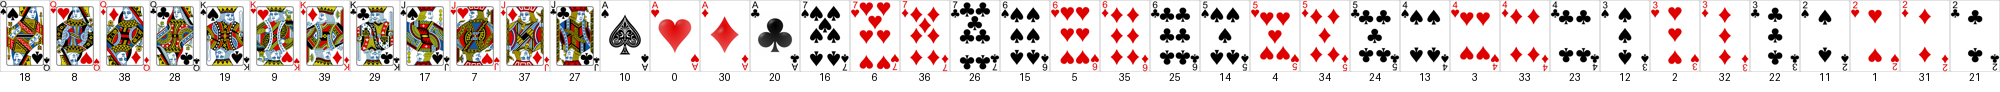

In [11]:
cards = preload_card_images()
# Create a horizontal grid of card images
grid_width = len(cards)
grid_height = 1
card_width, card_height = next(iter(cards.values())).size

# Create a new image with a white background
grid_image = Image.new("RGBA", (grid_width * card_width, grid_height * card_height + 20), (255, 255, 255, 255))
draw = ImageDraw.Draw(grid_image)

# Paste each card image into the grid and add their index below
for i, (index, card_image) in enumerate(cards.items()):
    grid_image.paste(card_image, (i * card_width, 0))
    draw.text((i * card_width + card_width // 2, card_height + 5), str(index), fill="black", anchor="mm")

# Save the grid image as SVG
grid_image.save("card_grid.png")

# Display the grid image
grid_image.show()


to implement and keep track on to see if algo is getting better
- difference in scores
- times a card that can captures is not chosen
- capture size of ace
- number of scopas overtime

In [ ]:
actor_states, states, actions, rewards, actor_new_states, states_, terminal = memory.sample_buffer()

print(f'Actor States: {actor_states}, States: {states}, Actions: {actions}, Rewards: {rewards}, Actor New States: {actor_new_states}, States_: {states_}, Terminal: {terminal}')

Actor States: [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 0.]]), array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])], States: [[0. 0. 